In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

##### ORIGINAL STEPS TO READ IN ALVARO CSVS

In [ ]:
# df15 = pd.read_csv('../clean_csv_files/alvaro_15.csv')
# df16 = pd.read_csv('../clean_csv_files/alvaro_16.csv')
# df17 = pd.read_csv('../clean_csv_files/alvaro_17.csv')
# df18 = pd.read_csv('../clean_csv_files/alvaro_18.csv')
# df19 = pd.read_csv('../clean_csv_files/alvaro_19.csv')

In [ ]:
# df_combined_1 = pd.concat([df15, df16, df17, df18, df19])
# df_combined_1.info()

In [ ]:
# df_combined_1.to_csv('../combined_csvs/alvaro_combined.csv', index=False)

##### READING IN COMBINED CSVS

In [2]:
combined_df = pd.read_csv('../combined_csvs/combined_vg_sales_summary.csv')

In [3]:
# New dataframe containing data for preprocessing
df_new = combined_df[['Genre','Summary']].copy()
df_new

,Genre,Summary
0,Sports,Wii Sports was developed by Nintendo to show t...
1,Platform,"For more than 25 years, the Super Mario series..."
2,Racing,Mario Kart Wii includes 16 new courses and 16 ...
3,Shooter,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...
4,Sports,"Wii Sports Resort is an immersive, expansive a..."
...,...,...
18854,Simulation,
18855,Shooter,"Infiltrate terrorists' positions, acquire crit..."
18856,Fighting,
18857,Adventure,


In [4]:
df_new['Genre'].value_counts()

Action              2786
Sports              2394
Misc                2123
Adventure           1789
Role-Playing        1728
Shooter             1475
Racing              1359
Simulation          1065
Platform            1061
Fighting             897
Strategy             831
Puzzle               706
Action-Adventure     316
Music                131
Visual Novel         110
MMO                   43
Party                 36
Sandbox                4
Education              3
Board Game             2
Name: Genre, dtype: int64

In [5]:
# combine genres with low counts into misc
# combine repeating genres, Action and Action
df_new.replace({'Genre': 
             {'Board Game':'Misc', 
              'Party':'Misc',
              'MMO': 'Misc',
              'Sandbox':'Misc',
              'Education':'Misc'
#               'Music':'Misc'
#               'Adventure':'Action-Adventure', 
#               'Action':'Action-Adventure'
             }}, 
            inplace= True)
df_new['Genre'].value_counts()

Action              2786
Sports              2394
Misc                2211
Adventure           1789
Role-Playing        1728
Shooter             1475
Racing              1359
Simulation          1065
Platform            1061
Fighting             897
Strategy             831
Puzzle               706
Action-Adventure     316
Music                131
Visual Novel         110
Name: Genre, dtype: int64

In [6]:
# encode genres as a value in a new column
df_new['Genre_ID'] = df_new['Genre'].factorize()[0]
genre_df = df_new[['Genre', 'Genre_ID']].drop_duplicates()
# genre_df
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18859 entries, 0 to 18858
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Genre     18859 non-null  object
 1   Summary   18859 non-null  object
 2   Genre_ID  18859 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 442.1+ KB


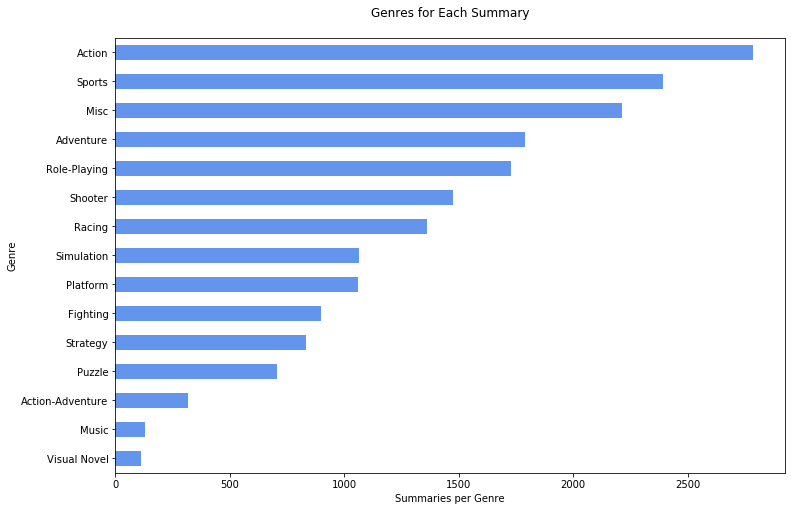

In [32]:
fig = plt.figure(figsize=(12,8))
df_new.groupby('Genre').Summary.count().sort_values().plot.barh(
    ylim=0, color='cornflowerblue', title= 'Genres for Each Summary\n')
plt.xlabel('Summaries per Genre', fontsize = 10);

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        #ngram_range=(1, 4), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_new['Summary']).toarray()
labels = df_new['Genre_ID']


In [8]:
features.shape

(18859, 39990)

In [9]:
genre_to_id = dict(genre_df.values)
genre_to_id

{'Sports': 0,
 'Platform': 1,
 'Racing': 2,
 'Shooter': 3,
 'Role-Playing': 4,
 'Puzzle': 5,
 'Misc': 6,
 'Simulation': 7,
 'Action': 8,
 'Action-Adventure': 9,
 'Fighting': 10,
 'Strategy': 11,
 'Adventure': 12,
 'Music': 13,
 'Visual Novel': 14}

In [10]:
id_to_genre = dict(genre_df[['Genre_ID', 'Genre']].values)
id_to_genre

{0: 'Sports',
 1: 'Platform',
 2: 'Racing',
 3: 'Shooter',
 4: 'Role-Playing',
 5: 'Puzzle',
 6: 'Misc',
 7: 'Simulation',
 8: 'Action',
 9: 'Action-Adventure',
 10: 'Fighting',
 11: 'Strategy',
 12: 'Adventure',
 13: 'Music',
 14: 'Visual Novel'}

In [11]:
# extracting the most common single and double word-phrases (unigrams, biigram, trigrams) in each genre
N = 40

for genre, genre_id in sorted(genre_to_id.items()):
        
    unigram = {}
##     bigram = {}
##     trigram = {}
    
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]

##     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
##     trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
        
    print("\nGenre: %s" %(genre))
    print("  * Unigram keywords are: %s" %(', '.join(unigrams[-N:])))
##     print("  * Bigram keywords are: %s" %(', '.join(bigrams[-N:])))
##     print("  * Trigram keywords are: %s" %(', '.join(trigrams[-N:])))



Genre: Action
  * Unigram keywords are: abilities, ghostbusters, voldemort, omnitrix, fu, stealth, kratos, film, incredibles, racing, assassins, comic, avengers, movie, platinumgames, thor, claire, redfield, films, evil, city, attacks, hulk, action, wolverine, marvel, dante, saints, resident, musou, assassin, transformers, bakugan, ninja, combat, spider, samurai, warriors, enemies, lego

Genre: Action-Adventure
  * Unigram keywords are: 3po, phasma, hux, dameron, kylo, poe, mistakenly, massachusetts, justcause, hopelessly, horseman, prematurely, blackgate, citizen, retold, laval, kenway, luthor, medici, flatbush, gulch, cuckoo, underprepared, darksiders, impa, triads, bilbo, doomstruction, doomstation, batman, spidey, zeroes, salem, bombur, thorin, ronan, hobbit, lego, superchargers, emmet

Genre: Adventure
  * Unigram keywords are: myst, seaworld, indiana, shamu, clannad, harry, evidence, witnesses, crime, sherlock, tantei, ncis, zelda, nancy, murder, d3, holmes, megamind, detective,

In [12]:
X = df_new['Summary'] # Collection of documents
y = df_new['Genre'] # Target or the labels we want to predict (i.e., the 15 different genres)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    #LinearSVC(),
    MultinomialNB(),
    #LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [13]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_new.index, test_size=0.30, 
                                                               random_state=1)
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
# report
print(metrics.classification_report(y_test, y_pred, target_names= df_new['Genre'].unique()))

                  precision    recall  f1-score   support

          Sports       0.76      0.67      0.71       726
        Platform       0.00      0.00      0.00       303
          Racing       0.99      0.35      0.52       397
         Shooter       1.00      0.01      0.03       469
    Role-Playing       1.00      0.00      0.01       497
          Puzzle       0.00      0.00      0.00       230
            Misc       0.83      0.08      0.14       653
      Simulation       0.00      0.00      0.00       319
          Action       0.17      0.98      0.29       837
Action-Adventure       0.00      0.00      0.00       100
        Fighting       1.00      0.00      0.01       279
        Strategy       0.00      0.00      0.00       254
       Adventure       0.00      0.00      0.00       515
           Music       0.00      0.00      0.00        44
    Visual Novel       0.00      0.00      0.00        35

        accuracy                           0.27      5658
       macro

C:\Users\a_mcr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
report = metrics.classification_report(y_test, y_pred,target_names= df_new['Genre'].unique(), output_dict=True)
df_class_report = pd.DataFrame(report).transpose()
df_class_report

,precision,recall,f1-score,support
Sports,0.761381,0.668044,0.711665,726.000000
Platform,0.000000,0.000000,0.000000,303.000000
Racing,0.992857,0.350126,0.517691,397.000000
Shooter,1.000000,0.014925,0.029412,469.000000
Role-Playing,1.000000,0.004024,0.008016,497.000000
Puzzle,0.000000,0.000000,0.000000,230.000000
Misc,0.830508,0.075038,0.137640,653.000000
Simulation,0.000000,0.000000,0.000000,319.000000
Action,0.171239,0.984468,0.291733,837.000000
Action-Adventure,0.000000,0.000000,0.000000,100.000000


In [20]:
import joblib

In [21]:
# save model
joblib.dump(model, "../saved_model/video_game_random_forest.joblib")

['../saved_model/video_game_random_forest.joblib']

In [ ]:
## load, no need to initialize the loaded_rf
# loaded_rf = joblib.load("../saved_model/video_game_random_forest.joblib")

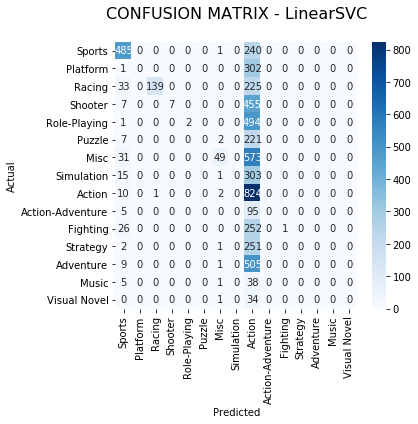

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=genre_df.Genre.values, 
            yticklabels=genre_df.Genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);
plt.tight_layout()
plt.savefig('../images/confusion_matrix.png')

#### Running new data through the the model predict

In [ ]:
game name, critic score
y total sales big x is critic score and do a train test split
train the forest model
do a predict with the x test
compare y predict to y test
numbers we want is the name of the game,  one hot encoding of the genre...

In [ ]:

data_dict = {"Genre": ["Action",  "Racing"],
            "Summary": ["When a young street hustler, a retired bank robber and a terrifying psychopath find themselves entangled with some of the most frightening and deranged elements of the criminal underworld, the U.S. government and the entertainment industry, they must pull off a series of dangerous heists to survive in a ruthless city in which they can trust nobody, least of all each other.", "4 CHANGES EVERYTHING. Dynamic seasons change everything at the world's greatest automotive festival. Go it alone or team up with others to explore beautiful and historic Britain in a shared open world. Collect, modify and drive over 450 cars. Race, stunt, create and explore – choose your own path to become a Horizon Superstar. The Forza Horizon 4 Standard Edition digital bundle includes the full game of Forza Horizon 4 and the Formula Drift Car Pack for Forza Horizon 4."]}
df_videogame = pd.DataFrame.from_dict(data_dict)
df_videogame

In [ ]:
Xnew = df_videogame['Summary'] # Collection of documents
ynew = df_videogame['Genre'] # Target or the labels we want to predict (i.e., the 15 different genres)

# X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, 
#                                                     test_size=0.30,
#                                                     random_state = 0)

In [ ]:
data_dict = {"Genre": ["Action",  "Racing"],
            "Summary": ["When a young street hustler, a retired bank robber and a terrifying psychopath find themselves entangled with some of the most frightening and deranged elements of the criminal underworld, the U.S. government and the entertainment industry, they must pull off a series of dangerous heists to survive in a ruthless city in which they can trust nobody, least of all each other.", "4 CHANGES EVERYTHING. Dynamic seasons change everything at the world's greatest automotive festival. Go it alone or team up with others to explore beautiful and historic Britain in a shared open world. Collect, modify and drive over 450 cars. Race, stunt, create and explore – choose your own path to become a Horizon Superstar. The Forza Horizon 4 Standard Edition digital bundle includes the full game of Forza Horizon 4 and the Formula Drift Car Pack for Forza Horizon 4."]}

In [ ]:
a = pd.DataFrame.from_dict(data_dict)
a

In [ ]:
# extracting the most common single and double word-phrases (biigram) in each genre
N = 10
## wordcloud = []

for genre, genre_id in sorted(genre_to_id.items()):
    
    
    unigram = {}
##     bigram = {}
##     trigram = {}
    
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
##     data[genre] = b=unigrams
##     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
##     data[genre] = bigrams
##     trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
##     data[genre] = trigrams
        
    print("\nGenre: %s" %(genre))
    print("  * Unigram keywords are: %s" %(', '.join(unigrams[-N:])))
##     print("  * Bigram keywords are: %s" %(', '.join(bigrams[-N:])))
##     print("  * Trigram keywords are: %s" %(', '.join(trigrams[-N:])))
##     wordcloud.append(data)


In [ ]:
features = tfidf.fit_transform(a['Summary']).toarray()
labels = a['Genre']

In [ ]:
len(tfidf.get_feature_names())

In [ ]:
newer_df = pd.DataFrame(features, columns = tfidf.get_feature_names())
newer_df

In [ ]:
# X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
#                                                                labels,
#                                                                a.index, test_size=0.30,
#                                                                random_state=1)
# model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
# model.fit(X_train, y_train)
y_pred = model.predict(newer_df)